In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
plt.rc("axes.spines", top=False, right=False)

from plotting_functions import plot_correlation, add_regression_line, cm2inch, show_img
from analysis_functions import compute_gaze_influence_score, compute_mean_rt, compute_p_choose_best, add_best_chosen, aggregate_subject_level
from analysis_functions import std, se, q1, q3, iqr

In [2]:
np.random.seed(84) # from random.org

# 2.2 Relative model fit (individual level model comparison)

## Load WAICs

In [3]:
waic_summaries = [file for file in os.listdir(os.path.join('results', 'model_comparison', 'additive_vs_multiplicative'))
                  if file.endswith('waic.csv')]

n_krajbich2010 = 39
n_krajbich2011 = 30
n_folke2016 = 24
n_tavares2017 = 25
n = n_krajbich2010 + n_krajbich2011 + n_folke2016 + n_tavares2017

waic = pd.DataFrame(dict(subject=np.arange(n)))
waic['dWAIC'] = np.nan
waic['dSE'] = np.nan
waic['dataset'] = np.nan
waic['warning'] = np.nan

for file in waic_summaries:
    _, _, _, subject, _ = file.split('_')
    subject = int(subject)

    waic_summary = pd.read_csv(os.path.join('results', 'model_comparison',
                                            'additive_vs_multiplicative', file), index_col='Unnamed: 0')
    waic.loc[waic['subject'] == subject, 'dWAIC'] = waic_summary.loc['GLAM', 'WAIC'] - waic_summary.loc['additive', 'WAIC']
    waic.loc[waic['subject'] == subject, 'dSE'] = waic_summary['dSE'].values[1]
    waic.loc[waic['subject'] == subject, 'warning'] = waic_summary['var_warn'].sum()

waic.sort_values('subject', inplace=True)
waic['dataset'] = np.array(n_krajbich2010 * ['krajbich2010'] + n_krajbich2011 * ['krajbich2011'] + n_folke2016 * ['folke2016'] + n_tavares2017 * ['tavares2017'])

waic.head()

,subject,dWAIC,dSE,dataset,warning
0,0,-0.90,0.99,krajbich2010,0.0
1,1,-1.19,3.06,krajbich2010,0.0
2,2,1.52,1.52,krajbich2010,0.0
3,3,-0.65,1.58,krajbich2010,0.0
4,4,-3.16,1.79,krajbich2010,0.0


# Plot WAIC differences between multiplicative and additive GLAM variants

### Panel a

In [4]:
def figure_si_2a(waic, colors=None, fontsize=7, figsize=cm2inch((18, 6)), plot_type='bar', log_scale=False, ylim=(-50, 100), plot_legend=True, ax=None):

    # Log transform: add minimum dWAIC + 1, then log-transform, new indifference then at log(minimum dWAIC + 1)
    waic = waic.copy()
    if log_scale:
        min_dWAIC = np.min(waic['dWAIC'])
        indifference_level = np.log(np.abs(min_dWAIC) + 1)
        waic['plotted_dWAIC'] = np.log(waic['dWAIC'] + np.abs(min_dWAIC) + 1)
    else:
        indifference_level = 0
        waic['plotted_dWAIC'] = waic['dWAIC']
    
    if colors is None:
        colors = np.array(['C{}'.format(i) for i in range(10)])

    datasets = ['krajbich2010', 'krajbich2011', 'folke2016', 'tavares2017']
    dataset_labels = ['Krajbich 2010', 'Krajbich 2011', 'Folke 2016', 'Tavares 2017']
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    sorting_idx = np.argsort(waic['plotted_dWAIC'])
    color_idx = pd.Categorical(waic['dataset'], categories=datasets).codes
    patches = []
    
    patches = [mpatches.Rectangle((0, 0), 0.5, 1, fc="C{}".format(i))
               for i in range(len(datasets))]

    for i, dataset in enumerate(datasets):

        if plot_type == 'bar':
            ax.bar(np.arange(len(waic))[waic['dataset'][sorting_idx] == dataset],
                   waic['plotted_dWAIC'][sorting_idx][waic['dataset'][sorting_idx] == dataset],
                   color=colors[i])

        else:
            ax.scatter(np.arange(len(waic))[waic['dataset'][sorting_idx] == dataset],
                       waic['plotted_dWAIC'][sorting_idx][waic['dataset'][sorting_idx] == dataset],
                       color=colors[i], marker='+')

    
    # Legend
    if plot_legend:
        ax.legend(patches,
                  ['Krajbich 2010', 'Krajbich 2011', 'Folke 2016', 'Tavares 2017'],
                  ncol=2,
                  loc='lower right',
                  handlelength=1, handleheight=1,
                  fontsize=fontsize, columnspacing=1,
                  frameon=False)
    
    
    ax.set_xlabel('Participant', fontsize=fontsize)
    if log_scale:
        ax.set_ylabel('Log(dWAIC))', fontsize=fontsize)
    else:
        ax.set_ylabel('WAIC(multiplicative)-\nWAIC(additive)', fontsize=fontsize)
    ax.set_xticks([])
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    
    ax.axhline(indifference_level, color='black', lw=1, zorder=9)
    
    ax.set_ylim(ylim)
    
    
    ax.text(-0.075, 1., 'a', transform=ax.transAxes,
                fontsize=7, fontweight='bold', va='top')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
        
    # Font sizes
    ax.tick_params(axis='both', labelsize=8)
    
    return ax

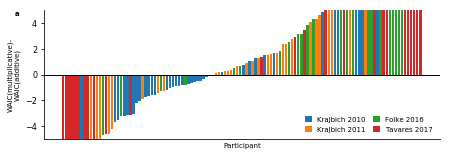

In [5]:
figure_si_2a(waic, ylim=(-5, 5));

In [6]:
waic['dWAIC'].describe()

count    118.000000
mean       2.100424
std       11.626632
min      -35.910000
25%       -1.605000
50%        0.720000
75%        5.157500
max       56.600000
Name: dWAIC, dtype: float64

In [7]:
(waic['dWAIC'] > 0).sum()

68

In [8]:
(waic['dWAIC'] > 0).sum() / len(waic)

0.576271186440678

### Paneld bcd

In [9]:
all_data = pd.read_csv('data/data_aggregate.csv')
even = all_data[(all_data['trial'] % 2) == 0].reset_index(drop=True)
odd = all_data[(all_data['trial'] % 2) == 1].reset_index(drop=True)

In [10]:
# read model predictions for multiplicative and additive variants and concatenate
prediction_additive_list = []
prediction_multiplicative_list = []

# join prediction dataframes
for subject in odd['subject'].unique():
    subject_pred_additive = pd.read_csv(os.path.join('results', 'predictions', 'out_of_sample', 'additive', 'prediction_{}_additive_oos.csv'.format(subject)), index_col=0)
    subject_pred_additive['subject'] = subject    
    prediction_additive_list.append(subject_pred_additive)

    subject_pred_multiplicative = pd.read_csv(os.path.join('results', 'predictions', 'out_of_sample', 'multiplicative', 'prediction_{}_multiplicative_oos.csv'.format(subject)), index_col=0)
    subject_pred_multiplicative['subject'] = subject
    prediction_multiplicative_list.append(subject_pred_multiplicative)

prediction_additive = pd.concat(prediction_additive_list)
prediction_multiplicative = pd.concat(prediction_multiplicative_list)

/Users/armin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/Users/armin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [11]:
# discard trials with negative predicted RT
prediction_additive = prediction_additive[prediction_additive['rt'] > 0].copy()
prediction_multiplicative = prediction_multiplicative[prediction_multiplicative['rt'] > 0].copy()

In [12]:
# compute / load individual behavioural measures for odd data and model predictions
odd_summary = pd.DataFrame()
data_summary = pd.DataFrame()
pred_additive_summary = pd.DataFrame()

for di, dataset in enumerate(odd['dataset'].unique()):
    odd_di = odd[odd['dataset'] == dataset].copy()
    n_items = odd_di['n_items'].unique()[0]
    
    odd_summary_di = aggregate_subject_level(odd_di, n_items=n_items)
    
    prediction_additive_di = prediction_additive[prediction_additive['dataset'] == dataset].copy()
    
    pred_additive_summary_di = aggregate_subject_level(prediction_additive_di, n_items=n_items)
    
    
    odd_summary = pd.concat([odd_summary, odd_summary_di])
    pred_additive_summary = pd.concat([pred_additive_summary, pred_additive_summary_di])

pred_additive_summary.to_csv(os.path.join('results', 'predictions', 'out_of_sample', 'descriptives',
                                          'subject_summary_additive_oos.csv'))

pred_multiplicative_summary = pd.read_csv(os.path.join('results',
                                                       'predictions',
                                                       'out_of_sample',
                                                       'descriptives',
                                                       'subject_summary_multiplicative_oos.csv'),
                                         header=[0, 1], index_col=0)
pred_additive_summary = pd.read_csv(os.path.join('results',
                                                 'predictions',
                                                 'out_of_sample',
                                                 'descriptives',
                                                 'subject_summary_additive_oos.csv'),
                                    header=[0, 1], index_col=0)

In [13]:
def figure_si_2bcd(multiplicative, additive,
                 figsize=cm2inch(18, 6), colors=None, fontsize=7, alpha=0.5, axs=None, plot_legend=False):

    datasets = ['krajbich2010', 'krajbich2011', 'folke2016', 'tavares2017']

    if colors is None:
        colors = np.array(['C{}'.format(i)
                           for i in range(multiplicative['dataset']['Unnamed: 11_level_1'].unique().size)])
    color_idx = pd.Categorical(multiplicative['dataset']['Unnamed: 11_level_1'], categories=datasets, ordered=True).codes.astype(int)
    
    if axs is None:
        fig, axs = plt.subplots(1, 3, figsize=figsize, sharex='col', sharey='col')

    # b) Mean RT
    axs[0].scatter(multiplicative['rt']['mean'],
                   additive['rt']['mean'],
                   color=colors[color_idx],
                   linewidth=0,
                   marker='o',
                   alpha=alpha)
    axs[0].scatter(multiplicative['rt']['mean'],
                   additive['rt']['mean'],
                   color=colors[color_idx],
                   facecolor='none',
                   linewidth=0.5,
                   marker='o',
                   alpha=1.0)
    axs[0].set_xticks(np.arange(0, 10000, 2000))
    axs[0].set_yticks(np.arange(0, 10000, 2000))
    axs[0].set_xlim(0, 9000)
    axs[0].set_ylim(0, 9000)


    # c) P(choose best)
    axs[1].scatter(multiplicative['best_chosen']['mean'],
                   additive['best_chosen']['mean'],
                   color=colors[color_idx],
                   linewidth=0,
                   marker='o',
                   alpha=alpha)
    axs[1].scatter(multiplicative['best_chosen']['mean'],
                   additive['best_chosen']['mean'],
                   color=colors[color_idx],
                   facecolor='none',
                   linewidth=0.5,
                   marker='o',
                   alpha=1.0)

    axs[1].set_xticks(np.arange(0.4, 1.1, 0.2))
    axs[1].set_yticks(np.arange(0.4, 1.1, 0.2))
    axs[1].set_xlim(0.2, 1.0)
    axs[1].set_ylim(0.2, 1.0)



    # d) Gaze Influence
    axs[2].scatter(multiplicative['gaze_influence']['Unnamed: 10_level_1'],
                   additive['gaze_influence']['Unnamed: 10_level_1'],
                   color=colors[color_idx],
                   marker='o',
                   linewidth=0,
                   alpha=alpha)
    axs[2].scatter(multiplicative['gaze_influence']['Unnamed: 10_level_1'],
                   additive['gaze_influence']['Unnamed: 10_level_1'],
                   color=colors[color_idx],
                   marker='o',
                   facecolor='none',
                   linewidth=0.5,
                   alpha=1.0)
    
    axs[2].set_xticks(np.arange(-0.2, 1.1, 0.2))
    axs[2].set_yticks(np.arange(-0.2, 1.1, 0.2))
    axs[2].set_xlim(-0.3, 0.85)
    axs[2].set_ylim(-0.3, 0.85)

    axs[0].set_ylabel('Additive variant predicted\nMean RT (ms)', fontsize=fontsize)
    axs[0].set_xlabel('Multiplicative variant predicted\nMean RT (ms)', fontsize=fontsize)

    axs[1].set_ylabel('Additive variant predicted\nP(choose best)', fontsize=fontsize)
    axs[1].set_xlabel('Multiplicative variant predicted\nP(choose best)', fontsize=fontsize)

    axs[2].set_ylabel('Additive variant predicted\nGaze influence', fontsize=fontsize)
    axs[2].set_xlabel('Multiplicative variant predicted\nGaze influence', fontsize=fontsize)
    
    patches = [mpatches.Rectangle((0, 0), 0.5, 1, fc="C{}".format(i))
               for i in range(len(datasets))]
    if plot_legend:
        axs[0].legend(patches,
                         ['Krajbich 2010', 'Krajbich 2011', 'Folke 2016', 'Tavares 2017'],
                         loc='upper left',
                         handlelength=1, handleheight=1,
                         fontsize=fontsize,
                         frameon=False)

    # Labels
    for label, ax in zip(list('bcd'), axs.ravel()):
        ax.text(-0.33, 1.1, label, transform=ax.transAxes,
                fontsize=fontsize, fontweight='bold', va='top')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Font sizes
        ax.tick_params(axis='both', labelsize=fontsize)

        # Plot diagonal
        ax.plot(ax.get_xlim(), ax.get_xlim(), color='black', linewidth=1, alpha=1.0, zorder=-1)
            
    return axs

## Panels efg (additive model parameters vs. behavioural measures) – in sample

In [14]:
odd_summary.head()

best_chosen           rt                                            \
               mean         mean          std     min      max          se   
subject                                                                      
0          0.822222  1704.177778   881.852300   682.0   4142.0  132.944236   
1          0.673469  1728.489796   857.141479   743.0   4602.0  123.717716   
2          0.840000  4078.660000  2623.044800   943.0  12079.0  374.720686   
3          0.704545  1893.545455   633.499496  1045.0   4742.0   96.607767   
4          0.840000  1846.640000  1093.485579   692.0   5891.0  156.212226   

                                  gaze_influence       dataset  
              q1      q3      iqr                               
subject                                                         
0        1125.00  1970.0   845.00      -0.020529  krajbich2010  
1        1166.00  1937.0   771.00       0.247233  krajbich2010  
2        2104.25  5329.0  3224.75       0.028877  krajbich2010  
3        1436.50  2175.5   739.00      -0.022031  krajbich2010  
4        1221.50  2132.5   911.00       0.103622  krajbich2010

In [15]:
estimates = pd.DataFrame()
parameter_names = ['v', 'gamma', 's', 'tau']
for subject in odd_summary.index:
    subject_estimates_df = pd.read_csv(os.path.join('results', 'estimates', 'out_of_sample', 'additive',
                                                    'estimates_{}_additive_oos.csv'.format(subject)),
                                       index_col=0)
    subject_estimates_dict = {parameter: subject_estimates_df.loc[parameter + '__0_0', 'MAP']
                              for parameter in parameter_names}
    subject_estimates_dict['subject'] = subject
    estimates = pd.concat([estimates,
                           pd.DataFrame(subject_estimates_dict,
                                        index=np.ones(1)*subject)])

estimates.head()

,gamma,s,subject,tau,v
0.0,1.78,0.008020,0,0.36,0.000096
1.0,7.87,0.010117,1,0.10,0.000100
2.0,0.49,0.008944,2,1.00,0.000023
3.0,1.11,0.004812,3,0.01,0.000089
4.0,6.00,0.009909,4,0.20,0.000092


In [16]:
def figure_si_2efg(estimates, summary,
                   figsize=cm2inch(18, 6), colors=None, fontsize=7, alpha=0.5, axs=None, plot_legend=False):

    datasets = ['krajbich2010', 'krajbich2011', 'folke2016', 'tavares2017']

    if colors is None:
        colors = np.array(['C{}'.format(i)
                           for i in range(summary['dataset'].unique().size)])
    color_idx = pd.Categorical(summary['dataset'], categories=datasets, ordered=True).codes.astype(int)
    
    if axs is None:
        fig, axs = plt.subplots(1, 3, figsize=figsize, sharex='col', sharey='col')

    # e) log Mean RT ~ log v
    axs[0].scatter(np.log(estimates['v']),
                   np.log(summary['rt']['mean']),
                   color=colors[color_idx],
                   marker='o',
                   linewidth=0,
                   alpha=alpha)
    axs[0].scatter(np.log(estimates['v']),
                   np.log(summary['rt']['mean']),
                   color=colors[color_idx],
                   marker='o',
                   facecolor='none',
                   linewidth=0.5,
                   alpha=1.0)
    axs[0].set_ylim(6, 9.125)
    
    # b) P(choose best) ~ gamma
    axs[1].scatter(estimates['gamma'],
                   summary['best_chosen']['mean'],
                   color=colors[color_idx],
                   marker='o',
                   linewidth=0,
                   alpha=alpha)
    axs[1].scatter(estimates['gamma'],
                   summary['best_chosen']['mean'],
                   color=colors[color_idx],
                   marker='o',
                   facecolor='none',
                   linewidth=0.5,
                   alpha=1.0)
    axs[1].set_ylim(0.3, 1.0)

    # c) Gaze Influence ~ gamma
    axs[2].scatter(estimates['gamma'],
                   summary['gaze_influence'],
                   color=colors[color_idx],
                   marker='o',
                   linewidth=0,
                   alpha=alpha)
    axs[2].scatter(estimates['gamma'],
                   summary['gaze_influence'],
                   color=colors[color_idx],
                   marker='o',
                   linewidth=0.5,
                   facecolor='none',
                   alpha=1.0)

    axs[0].set_ylabel('Log mean RT (ms)', fontsize=fontsize)
    axs[1].set_ylabel('P(choose best)', fontsize=fontsize)
    axs[2].set_ylabel('Gaze influence\non P(choice | value)', fontsize=fontsize)
     
    axs[0].set_xlabel(r'Log $\hat{v}$', fontsize=fontsize)
    axs[1].set_xlabel(r'$\hat{\gamma}_{additive}$', fontsize=fontsize)
    axs[2].set_xlabel(r'$\hat{\gamma}_{additive}$', fontsize=fontsize)
    
    patches = [mpatches.Rectangle((0, 0), 0.5, 1, fc="C{}".format(i))
               for i in range(len(datasets))]
    if plot_legend:
        axs[0].legend(patches,
                         ['Krajbich 2010', 'Krajbich 2011', 'Folke 2016', 'Tavares 2017'],
                         loc='upper left',
                         handlelength=1, handleheight=1,
                         fontsize=fontsize,
                         frameon=False)

    # Labels
    for label, ax in zip(list('efg'), axs.ravel()):
        ax.text(-0.3, 1.1, label, transform=ax.transAxes,
                fontsize=fontsize, fontweight='bold', va='top')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Font sizes
        ax.tick_params(axis='both', labelsize=fontsize)
            
    return axs

# Mixed effects regressions with random slope and intercept for data sets

In [17]:
from bambi import Model
from pymc3 import plot_posterior

In [18]:
# Format data for mixed model
df = pd.concat([estimates, odd_summary], axis=1)
df['log_rt'] = np.log(df[('rt', 'mean')])
df['log_v'] = np.log(df['v'])
df['best_chosen'] = 100 * df[('best_chosen', 'mean')]
df['gaze_influence'] = 100 * df[('gaze_influence', '')]
df['dataset'] = df[('dataset', '')]

df = df[['subject', 'dataset', 'log_rt', 'best_chosen', 'gaze_influence', 'log_v', 'gamma', 's', 'tau']].copy().reset_index(drop=True)

In [19]:
df.head()

,subject,dataset,log_rt,best_chosen,gaze_influence,log_v,gamma,s,tau
0,0,krajbich2010,7.440838,82.222222,-2.052946,-9.251162,1.78,0.008020,0.36
1,1,krajbich2010,7.455003,67.346939,24.723267,-9.210340,7.87,0.010117,0.10
2,2,krajbich2010,8.313524,84.000000,2.887728,-10.680016,0.49,0.008944,1.00
3,3,krajbich2010,7.546206,70.454545,-2.203105,-9.326874,1.11,0.004812,0.01
4,4,krajbich2010,7.521123,84.000000,10.362165,-9.293722,6.00,0.009909,0.20


In [20]:
n_samples = 20000

In [21]:
result_file = os.path.join('results', 'mixed_effects_models', 'si2_parameter_behavior_e_v_rt.csv')

if not os.path.isfile(result_file):

    model_e = Model(df)
    result_e = model_e.fit('log_rt ~ log_v',
                           random=['log_v|dataset'],
                           categorical=['dataset'],
                           samples=n_samples,
                           chains=2)

    summary_e = result_e.summary(ranefs=True)
    summary_e.to_csv(result_file)
else:
    print('Loading previous results from "{}"...'.format(result_file))
    summary_e = pd.read_csv(result_file, index_col=0)
summary_e

Loading previous results from "results/mixed_effects_models/si2_parameter_behavior_e_v_rt.csv"...


,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
1|dataset[folke2016],-0.017646,0.295195,-0.634416,0.423502,3525,1.004311
1|dataset[krajbich2010],0.033198,0.243402,-0.416619,0.590320,6036,1.000039
1|dataset[krajbich2011],-0.125765,0.286000,-0.728672,0.257428,2929,1.004666
1|dataset[tavares2017],-0.071335,0.278042,-0.640520,0.357967,3211,1.005446
1|dataset_sd,0.231486,0.306003,0.000026,0.828555,2254,1.008188
Intercept,-0.033978,0.354079,-0.689633,0.629774,3947,1.000531
log_rt_sd,0.124105,0.008430,0.108121,0.140994,31014,1.000250
log_v,-0.798045,0.038026,-0.868558,-0.728922,3577,1.001977
log_v|dataset[folke2016],-0.012266,0.032372,-0.077977,0.032816,2263,1.007202
log_v|dataset[krajbich2010],0.003156,0.026932,-0.042481,0.064316,4049,1.000501


In [22]:
result_file = os.path.join('results', 'mixed_effects_models', 'si2_parameter_behavior_f_gamma_best_chosen.csv')

if not os.path.isfile(result_file):
    model_f = Model(df)
    result_f = model_f.fit('best_chosen ~ gamma',
                           random=['gamma|dataset'],
                           categorical=['dataset'],
                           samples=n_samples,
                           chains=2)
    summary_f = result_f.summary(ranefs=True)
    summary_f.loc['gamma', 'P(>0)'] = np.mean(model_f.backend.trace.get_values('gamma') > 0)
    summary_f.to_csv(result_file)
else:
    print('Loading previous results from "{}"...'.format(result_file))
    summary_f = pd.read_csv(result_file, index_col=0)
summary_f

Loading previous results from "results/mixed_effects_models/si2_parameter_behavior_f_gamma_best_chosen.csv"...


,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin,P(>0)
1|dataset[folke2016],-5.956513,4.364543,-14.871410,2.138893,1592,1.000831,NaN
1|dataset[krajbich2010],1.396610,4.054223,-6.568707,9.555024,1428,1.001228,NaN
1|dataset[krajbich2011],-1.574253,4.180720,-10.024388,6.637936,1579,1.000950,NaN
1|dataset[tavares2017],7.815341,4.592465,-0.879668,16.995088,1711,1.000650,NaN
1|dataset_sd,7.232852,3.171432,1.807807,13.893732,2905,1.000337,NaN
Intercept,81.765392,3.981087,73.935827,89.675620,1283,1.001253,NaN
best_chosen_sd,8.065718,0.552239,7.010017,9.160790,31223,0.999975,NaN
gamma,-0.538628,0.217739,-0.966284,-0.058808,10852,0.999996,0.0207
gamma|dataset[folke2016],-0.140555,0.237380,-0.686321,0.280260,10451,0.999984,NaN
gamma|dataset[krajbich2010],0.091832,0.230552,-0.378361,0.607520,14686,0.999975,NaN


Results loaded from: results/mixed_effects_models/si2_parameter_behavior_f_gamma_best_chosen_posteriorplot.png


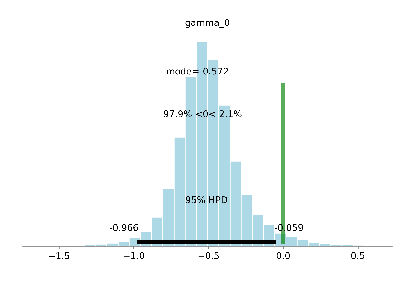

In [23]:
plot_path = os.path.join('results', 'mixed_effects_models', 'si2_parameter_behavior_f_gamma_best_chosen_posteriorplot.png')
if not os.path.isfile(plot_path):
    plot_posterior(model_f.backend.trace, varnames=['gamma'], ref_val=0, color='lightblue', point_estimate='mode');
    plt.savefig(plot_path, dpi=330)
else:
    print('Results loaded from: {}'.format(plot_path))
    show_img(plot_path)

In [24]:
result_file = os.path.join('results', 'mixed_effects_models', 'si2_parameter_behavior_g_gamma_gaze_influence.csv')

if not os.path.isfile(result_file):
    model_g = Model(df)
    result_g = model_g.fit('gaze_influence ~ gamma',
                           random=['gamma|dataset'],
                           categorical=['dataset'],
                           samples=n_samples,
                           chains=2)
    summary_g = result_g.summary(ranefs=True)
    summary_g.to_csv(result_file)
else:
    print('Loading previous results from "{}"...'.format(result_file))
    summary_g = pd.read_csv(result_file, index_col=0)
summary_g

Loading previous results from "results/mixed_effects_models/si2_parameter_behavior_g_gamma_gaze_influence.csv"...


,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
1|dataset[folke2016],7.838711,5.920029,-2.964167,20.959486,255,1.004774
1|dataset[krajbich2010],-0.917145,5.152000,-10.203787,11.755268,321,1.003224
1|dataset[krajbich2011],-2.807166,5.433637,-14.244069,8.511666,415,1.002254
1|dataset[tavares2017],-5.238224,5.682959,-17.446861,5.351413,576,1.002131
1|dataset_sd,8.207836,4.639112,0.018719,17.421341,236,1.005395
Intercept,12.555314,5.025853,-0.962339,20.862518,272,1.003865
gamma,1.290620,0.469369,0.275879,2.213973,182,1.006930
gamma|dataset[folke2016],-0.462050,0.479151,-1.393693,0.629058,247,1.004655
gamma|dataset[krajbich2010],0.717301,0.528250,-0.251101,1.838689,195,1.006853
gamma|dataset[krajbich2011],0.365913,0.528746,-0.684177,1.458000,202,1.006510


# Figure SI 2

In [25]:
def figure_si_2(waic, 
                pred_multiplicative_summary, pred_additive_summary, 
                estimates, odd_summary, summary_e, summary_f, summary_g, 
                figsize=cm2inch(18, 18)):
    
    fig = plt.figure(figsize=figsize)
    
    ax0 = plt.subplot2grid((3, 3), (0, 0), colspan=3)
    ax1 = plt.subplot2grid((3, 3), (1, 0))
    ax2 = plt.subplot2grid((3, 3), (1, 1))
    ax3 = plt.subplot2grid((3, 3), (1, 2))
    ax4 = plt.subplot2grid((3, 3), (2, 0))
    ax5 = plt.subplot2grid((3, 3), (2, 1))
    ax6 = plt.subplot2grid((3, 3), (2, 2))
    
    figure_si_2a(waic, ylim=(-5, 5), ax=ax0)
    figure_si_2bcd(pred_multiplicative_summary, pred_additive_summary, axs=np.array([ax1, ax2, ax3]), plot_legend=False)
    figure_si_2efg(estimates, odd_summary, axs=np.array([ax4, ax5, ax6]), plot_legend=False)
    
    add_regression_line(ax4, summary_e.loc['Intercept', 'mean'], summary_e.loc['log_v', 'mean'], linewidth=1)
    add_regression_line(ax5, summary_f.loc['Intercept', 'mean'] / 100, summary_f.loc['gamma', 'mean'] / 100, linewidth=1)
    add_regression_line(ax6, summary_g.loc['Intercept', 'mean'] / 100, summary_g.loc['gamma', 'mean'] / 100, linewidth=1)
    
    fig.tight_layout()
    
    return fig, [ax0, ax1, ax2, ax3, ax4, ax5, ax6]

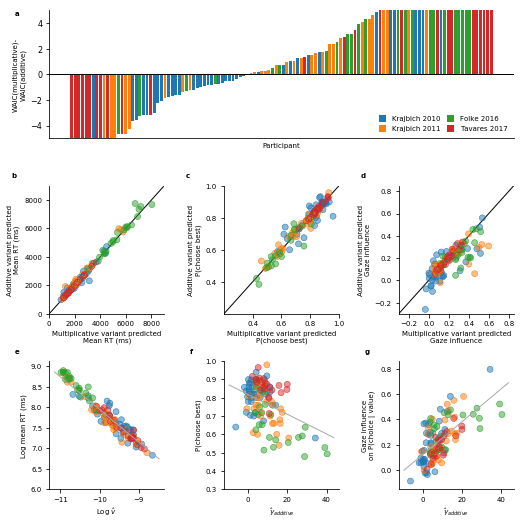

In [26]:
figure_si_2(waic,
            pred_multiplicative_summary, pred_additive_summary, 
            estimates, odd_summary, summary_e, summary_f, summary_g,
            figsize=cm2inch(18.8, 18.8))
plt.savefig('results/figures/si_figure_2_multiplicative_vs_additive.png', dpi=330, bbox_inches='tight')
plt.savefig('results/figures/si_figure_2_multiplicative_vs_additive.pdf', dpi=330, bbox_inches='tight')
plt.show()

# Bias Anlaysis: Multiplicative vs additive (b - d)

In [27]:
# Prepare data for mixed model
mean_rt = np.concatenate([pred_multiplicative_summary['rt']['mean'].values,
                          pred_additive_summary['rt']['mean'].values],
                         axis=0)
best_chosen = np.concatenate([pred_multiplicative_summary['best_chosen']['mean'].values,
                              pred_additive_summary['best_chosen']['mean'].values],
                             axis=0)
gaze_influence = np.concatenate([pred_multiplicative_summary['gaze_influence']['Unnamed: 10_level_1'].values,
                                 pred_additive_summary['gaze_influence']['Unnamed: 10_level_1'].values],
                                axis=0)

is_pred = np.concatenate([np.zeros(len(pred_multiplicative_summary)),
                          np.ones(len(pred_additive_summary))],
                         axis=0)
dataset = np.concatenate([pred_multiplicative_summary['dataset']['Unnamed: 11_level_1'].values,
                          pred_additive_summary['dataset']['Unnamed: 11_level_1'].values],
                         axis=0)

df = pd.DataFrame(dict(mean_rt=mean_rt,
                       best_chosen=best_chosen,
                       gaze_influence=gaze_influence,
                       is_pred=is_pred,
                       dataset=dataset))

df.head()

,best_chosen,dataset,gaze_influence,is_pred,mean_rt
0,0.904889,krajbich2010,0.077317,0.0,1434.192000
1,0.640000,krajbich2010,0.216067,0.0,1443.249796
2,0.836000,krajbich2010,0.007773,0.0,4486.572000
3,0.656818,krajbich2010,0.128273,0.0,1966.197273
4,0.744800,krajbich2010,0.387967,0.0,1650.926400


In [28]:
# Response time
result_file = os.path.join('results', 'mixed_effects_models', 'si2_multiplicative_vs_additive_b_bias_analysis_mean_rt.csv')
if not os.path.isfile(result_file):
    model = Model(df)
    results_mean_rt = model.fit('mean_rt ~ is_pred',
                                random=['is_pred|dataset'],
                                categorical=['dataset'],
                                samples=n_samples)
    bias_analysis_rt = results_mean_rt.summary(ranefs=True)
    bias_analysis_rt.to_csv(result_file)
else:
    bias_analysis_rt = pd.read_csv(result_file)
bias_analysis_rt

/Users/armin/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/armin/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
100%|██████████| 20500/20500 [06:37<00:00, 51.57it/s]


,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
1|dataset[folke2016],2411.939624,783.682426,945.532115,4083.413845,1037,1.003806
1|dataset[krajbich2010],-754.656982,780.124260,-2332.521320,782.723822,1028,1.004018
1|dataset[krajbich2011],-472.190196,780.180037,-1994.365735,1134.551428,1034,1.003866
1|dataset[tavares2017],-974.565860,781.390434,-2540.822790,578.008808,1044,1.003929
1|dataset_sd,1603.209883,510.863162,768.785500,2627.723891,5484,0.999998
Intercept,2885.032930,773.930468,1319.723919,4411.363359,994,1.004175
is_pred,54.091147,188.102917,-321.004097,446.042543,1728,1.001060
is_pred|dataset[folke2016],19.887457,195.527131,-406.321185,449.034240,3814,1.000408
is_pred|dataset[krajbich2010],-13.975746,185.285549,-433.450621,384.183365,2665,1.000679
is_pred|dataset[krajbich2011],13.146100,192.480963,-406.446400,441.020989,3185,1.000508


In [29]:
# P(choose best)
result_file = os.path.join('results', 'mixed_effects_models', 'si2_multiplicative_vs_additive_c_bias_analysis_p_choose_best.csv')
if not os.path.isfile(result_file):
    model = Model(df)
    results_best_chosen = model.fit('best_chosen ~ is_pred',
                                    random=['is_pred|dataset'],
                                    categorical=['dataset'],
                                    samples=n_samples)
    bias_analysis_best_chosen = results_best_chosen.summary(ranefs=True)
    bias_analysis_best_chosen.to_csv(result_file)
else:
    bias_analysis_best_chosen = pd.read_csv(result_file)
bias_analysis_best_chosen

/Users/armin/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/armin/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
100%|██████████| 20500/20500 [02:20<00:00, 146.10it/s]


,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
1|dataset[folke2016],-0.120035,0.060581,-2.437992e-01,-0.002041,1463,1.000732
1|dataset[krajbich2010],0.066649,0.060176,-5.675721e-02,0.183044,1491,1.000825
1|dataset[krajbich2011],-0.042117,0.060181,-1.666782e-01,0.073122,1434,1.000832
1|dataset[tavares2017],0.100450,0.060592,-2.251710e-02,0.217242,1415,1.000883
1|dataset_sd,0.112360,0.039678,4.858309e-02,0.193332,4040,1.000420
Intercept,0.744138,0.059464,6.266083e-01,0.864358,1381,1.000790
best_chosen_sd,0.100208,0.004697,9.089373e-02,0.109263,31879,1.000028
is_pred,-0.001118,0.020210,-4.017085e-02,0.039644,5135,0.999992
is_pred|dataset[folke2016],-0.003717,0.020709,-4.976389e-02,0.038933,6722,1.000263
is_pred|dataset[krajbich2010],0.000312,0.019871,-4.453433e-02,0.040837,4895,1.000034


In [30]:
# Gaze influence on P(choose | value)
result_file = os.path.join('results', 'mixed_effects_models', 'si2_multiplicative_vs_additive_d_bias_analysis_gaze_influence.csv')
if not os.path.isfile(result_file):
    model = Model(df)
    results_gaze_influence = model.fit('gaze_influence ~ is_pred',
                                       random=['is_pred|dataset'],
                                       categorical=['dataset'],
                                       samples=n_samples)
    bias_analysis_gaze_influence = results_gaze_influence.summary(ranefs=True)
    bias_analysis_gaze_influence.to_csv(result_file)
else:
    bias_analysis_gaze_influence = pd.read_csv(result_file)
bias_analysis_gaze_influence

/Users/armin/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/Users/armin/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)
100%|██████████| 20500/20500 [01:52<00:00, 182.65it/s]


,mean,sd,hpd0.95_lower,hpd0.95_upper,effective_n,gelman_rubin
1|dataset[folke2016],0.074984,0.042236,-0.005754,0.164354,6441,0.999975
1|dataset[krajbich2010],-0.051544,0.040483,-0.135949,0.030096,5836,1.000012
1|dataset[krajbich2011],0.001115,0.040879,-0.084181,0.082608,6073,0.999975
1|dataset[tavares2017],-0.018472,0.041482,-0.107063,0.062718,6055,0.999989
1|dataset_sd,0.074467,0.035068,0.021448,0.144084,5703,0.999979
Intercept,0.217709,0.039171,0.138780,0.301128,5342,0.999978
gaze_influence_sd,0.129316,0.005046,0.120500,0.138645,17965,1.000318
is_pred,-0.036538,0.027552,-0.095454,0.015632,4043,1.000270
is_pred|dataset[folke2016],-0.005839,0.029356,-0.073901,0.051738,5214,1.000248
is_pred|dataset[krajbich2010],-0.003809,0.027802,-0.065703,0.053565,4615,1.000388
